# Bird Flocking by Alicja
In this notebook the implementation of the bird flocking behaviour in R is performed. Furtherly the animation is created. 

## Assumptions
* Birds are represented by boids. 
* Each boid has its own position and velocity (object). 
* Boids are saved in a list of boids. 
* Boids move within a box (instead of classic periodic boundary conditions, easier to implement in R). If they land at the barrier of the box they bounce from it.
* Three rules govern the motion of the boids - alignment, cohesion and separation.
* After each iteration of the updates for all the system the coordinates are saved to the dataframe which is furtherly animated using gganimate.

## Algorithm
* In each time step we iterate through the list of boids. 
* For each boid in a list: 

-> we firstly move it according to its velocity (position=position+dt velocity, dt=1).

-> we extract the list of its neighbour in a circle of r and some angle range (boid look only in some spectrum, e.g 70 degrees forward)

-> we perform changes to its velocity according to the separtion, cohesion and alignment restrictions with respect to its neighbourhood.

-> we take its position and save it to the dataframe (pos_x, pos_y, boid_numer, current time)

* We animate the dataframe by placing the dots in a plot and animating over column with time.

* SEPARATION: if distance <=minimal_distance : boid@velocity = boid@velocity - weight*(neighbour@position - boid@position)
* ALIGNMENT: boid@velocity = boid@velocity + weight*(mean(neighbours' velocities)-boid@velocity) 
* COHESION: boid@velocity = boid@velocity + weight*(mean(neighbour's positions)-boid@position)


In [1]:
library("gganimate")

Warning message:
"package 'gganimate' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"

### Algorithm:
For each iteration in time and for each boid:

-> move the current boid according to the current velocity and save the current position

-> update its velocity according to the rules

In other words: we performed all the movements according to the previous settled velocities, however when we iterate over boids we change its velocity. When I move to the next boid and calculate something taking into account the old boid I do it with repsect to the updated values

In [54]:
boid1 <- list(pos = 0, velocity = 0) 
boid2 <- list(pos = 1, velocity = 3)
class(boid1)<-"boid"
class(boid2)<-"boid"

In [2]:
setClass("boid", slots=list(pos_x="numeric",pos_y="numeric", v_x="numeric", v_y="numeric"))

# instead of classic periodic boundary conditions the ball bounces from the walls
pbc<-function(boid, box){
    
    if (boid@pos_x>box){
        boid@pos_x = box
        boid@v_x = -boid@v_x
    }
    
    if (boid@pos_x<0){
        boid@pos_x = 0.0001
        boid@v_x = -boid@v_x
    }
    
    if (boid@pos_y>box){
        boid@pos_y = box
        boid@v_y = -boid@v_y
    }
    
    if (boid@pos_y<0){
        boid@pos_y = 0.0001
        boid@v_y = -boid@v_y
    }
    return(boid)
}

move_boid <- function(boid, box){
    dt=1
    #move by velocity
    x = boid@pos_x+boid@v_x*dt
    y = boid@pos_y+boid@v_y*dt
    boid@pos_x = x
    boid@pos_y = y
    boid = pbc(boid, box)
    return(boid)
}

In [3]:
calculate_distance <- function(boid1, boid2){
    distance = (boid1@pos_x-boid2@pos_x)**2 + (boid1@pos_y-boid2@pos_y)**2
    return(sqrt(distance))
}

In [4]:
calculate_angle <- function(boid1, boid2){ 
    #we will use a dot product (x1,x2) dot product (y1, y2) = x1*y1+x2*y2 = length(x1)*length(x2) cos(angle between them)
    scalar = boid1@pos_x*boid2@pos_x+boid1@pos_y*boid2@pos_y
    length1 = sqrt(boid1@pos_x**2 + boid1@pos_y**2)
    length2 = sqrt(boid2@pos_x**2 + boid2@pos_y**2)
    
    if (length1==0){
        length1=0.01
    }
    if (length2==0){
        length2=0.01
    }
    
    if(scalar/(length1*length2) >1 | scalar/(length1*length2) < (-1)){
    print("error")
    print(scalar/(length1*length2))
    print("boid1")
    print(boid1)
    print("boid2")
    print(boid2)}
    
    angle = acos(scalar/(length1*length2)) #arcus cosinus
    return(180*angle/pi) # return in normal degrees
}

In [5]:
boid1 <- new("boid", pos_x=1 ,pos_y=1, v_x=1, v_y=1)
boid2 <-new("boid", pos_x=2 ,pos_y=1, v_x=1, v_y=1)
calculate_angle(boid1, boid2)

[1] 18.43495

In [6]:
define_neigbourhood <- function(boid, list_of_boids, range_r, range_alpha){
    neighbours = c()
    index=1
    for (some_boid in list_of_boids){
        if (some_boid@pos_x!=boid@pos_x && some_boid@pos_y!=boid@pos_y && some_boid@v_x!=boid@v_x &&some_boid@v_y!=boid@v_y){
            
            D = calculate_distance(some_boid, boid)
            if(D <= range_r){ #boid within a distance
                angle = calculate_angle(some_boid, boid)
                if (angle <= range_alpha){
                    neighbours = c(neighbours, some_boid)
                    index = index+1
                }
            }
        
        }
        
    }
    
    return(neighbours)
}

In [7]:
alignment <- function(boid, neighbours, weight){ #velocity in the same directions
    if (length(neighbours) == 0 ){
    }
    else{
        velocities_x = c()
        velocities_y = c()
        N = length(neighbours)
        for (some_boid in neighbours){
            velocities_x = c(velocities_x, some_boid@v_x)
            velocities_y = c(velocities_y, some_boid@v_y)
        }
        boid@v_x = boid@v_x + weight*(mean(velocities_x)-boid@v_x) # przez N bylo
        boid@v_y = boid@v_y + weight*(mean(velocities_y)-boid@v_y) # przez N bylo
    }
    return(boid)
}

In [8]:
separation <- function(boid, neighbours, weight, minimal_distance){ #according to the first solution in the slides (slide 42)
    
    for (neighbour in neighbours){
        D = calculate_distance(boid, neighbour)
        if (D<=minimal_distance){
            boid@v_x = boid@v_x - weight*(neighbour@pos_x - boid@pos_x)
            boid@v_y = boid@v_y - weight*(neighbour@pos_y - boid@pos_y)
        }
    }
    return(boid)
    
}

In [9]:
cohesion <- function(boid, neighbours, weight){ # fly in group

    if (length(neighbours) == 0){}
    else{
        #print("in else")
        R_x = c()
        R_y = c()
        N = length(neighbours)
        for (some_boid in neighbours){
            R_x = c(R_x, some_boid@pos_x)
            R_y = c(R_y, some_boid@pos_y)
        }
    
        boid@v_x = boid@v_x + weight*(mean(R_x)-boid@pos_x) #mean przez N bylo
        boid@v_y = boid@v_y + weight*(mean(R_y)-boid@pos_y) #mean przez N bylo
    }

    return(boid)
}

In [10]:
init_simulation <- function(number_of_boids, box){
    list_of_boids=c()
    for (i in 1:number_of_boids){
        x = sample(1:box, 1)
        y = sample(1:box, 1)
        v_x = runif(1, min=-1.2, max=1.2)*3
        v_y = runif(1, min=-1.2, max=1.2)*3
        list_of_boids <- c(list_of_boids, new("boid",pos_x=x ,pos_y=y, v_x=v_x, v_y=v_y))
    }
    return(list_of_boids)
}

In [12]:
# ranges needed for neighbourhood definition
run_simulation <- function(number_of_boids, box, T, range_r, 
                           range_alpha, alignment_strength, minimal_separation, separation_strength, cohesion_strength){
    pos_xs = c()
    pos_ys = c()
    boid_number = rep(seq(1, number_of_boids),T)
    time = c()
    
    boids_list = init_simulation(number_of_boids, box)
    
    index=1
    for (t in 1:T){
        
        for (boid_index in 1:number_of_boids){
            
            # take a current boid
            current_boid = boids_list[[boid_index]]
            
            new_boid = move_boid(current_boid, box)
            current_boid = new_boid
            
            # change velocity according to different rules
            # first get the neighbours
            neighbours = define_neigbourhood(current_boid, boids_list, range_r, range_alpha)
            
            # update velocity according to the alignment
            #current_boid = alignment(current_boid, neighbours, alignment_strength)

            #updatae velocity according to the minimal separation
            current_boid = separation(current_boid, neighbours, separation_strength, minimal_separation)

            # update by cohesion
            current_boid = cohesion(current_boid, neighbours, cohesion_strength)
            
            #update the list of boids by providing the newest boid
            boids_list[[boid_index]] = current_boid
            
            # save position to the list for gganiamate
            pos_xs[index] = current_boid@pos_x
            pos_ys[index] = current_boid@pos_y
            index = index+1
        }
        time = c(time, rep(t,number_of_boids))
    }
    
    data = data.frame(pos_xs = pos_xs, pos_ys = pos_ys, boid_number = boid_number, time = time)
    return(data)
    
}

In [13]:
number_of_boids=20
box=200
T=100
range_r=10
range_alpha=80
alignment_strength=0.4
separation_strength=0.4
minimal_separation=40
cohesion_strength=0.3

data = run_simulation(number_of_boids, box, T, range_r, range_alpha,
                      alignment_strength, separation_strength, minimal_separation, cohesion_strength)

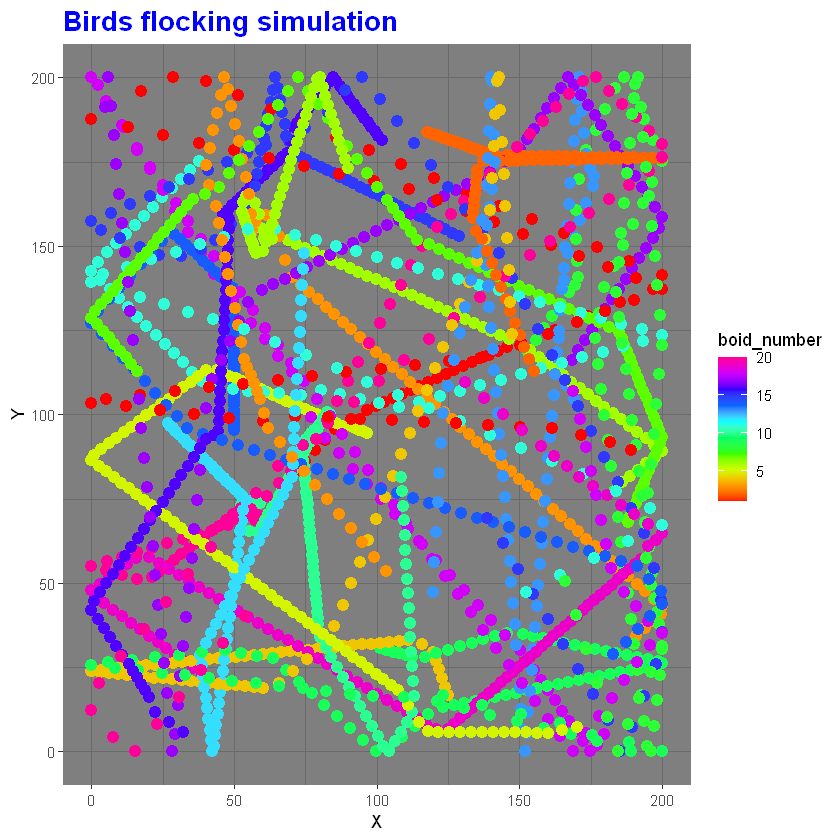

In [14]:
p <- ggplot(data, aes(x = pos_xs, y=pos_ys, color=boid_number))+geom_point(size=3)+
        scale_color_gradientn(colors = rainbow(10))+
        theme_dark()+theme(plot.title = element_text(color="Blue", size=17, face="bold"))+xlab("X")+ylab("Y")+
         ggtitle("Birds flocking simulation")

#low="yellow", high="red")
        #scale_fill_gradient(low="blue", high="red")
#scale_colour_manual(values = rainbow(10)) 
p

In [15]:
ani<-p + transition_time(time)
animate(ani, height = 500, width =500, renderer = gifski_renderer(loop = T), fps=6)

x,y,t
1,1,1
2,3,2
3,4,3
4,7,4
5,8,5
6,9,6
